In [37]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [38]:
from fastsim import simdrive, vehicle, cycle

In [39]:
def get_path(bucket, name):
    input_path = Path.cwd().parent / 'Data' / 'Cycle Data' / 'Original'
    return (input_path / bucket / name).with_suffix('.csv')

def get_cycle(path):
    t0 = time.time()
    cyc = cycle.Cycle(cyc_file_path=path)
    cyc_jit = cyc.get_numba_cyc()
    print(f'Time to load cycle: {time.time() - t0:.2e} s')
    return cyc, cyc_jit

In [40]:
cyc, cyc_jit = get_cycle(get_path('0_0','CORREDOR ACASA'))

Time to load cycle: 1.69e-02 s


In [41]:
t0 = time.time()
veh = vehicle.Vehicle(22)
veh_jit = veh.get_numba_veh()
print(f'Time to load vehicle: {time.time() - t0:.2e} s')

Time to load vehicle: 6.34e+00 s


In [42]:
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
#initSoc = 0.7935
#sim_drive.essCurKwh[0] = initSoc * sim_drive.veh.maxEssKwh
sim_drive.sim_drive() # REPLACE WITH SIMULATION OF ENERGY CONSUMPTION
print(f'Time to simulate: {time.time() - t0:.2e} s')


t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(f'Time to post process: {time.time() - t0:.2e} s')

Time to simulate: 3.34e+01 s
Time to post process: 7.37e-01 s


In [43]:
df = pd.DataFrame.from_dict(output)
df['speed'] = cyc.cycMps * 2.23694  # Convert mps to mph

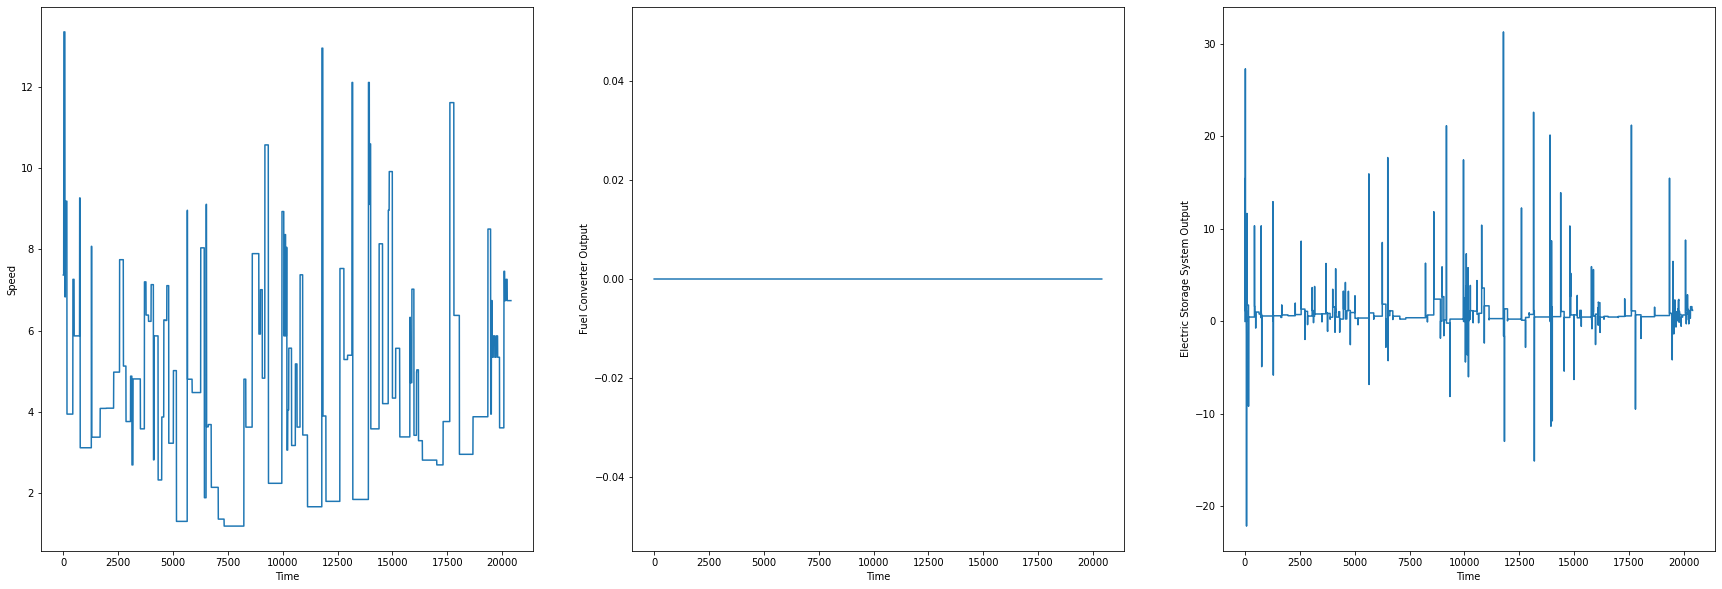

In [44]:
fig, ax = plt.subplots(1,3, figsize = (30,10))

for i in range(3): ax[i].set_xlabel('Time')
    
ax[0].plot(df['time'],df['speed'])
ax[0].set_ylabel('Speed')
ax[1].plot(df['time'],sim_drive.fcKwOutAch)
ax[1].set_ylabel('Fuel Converter Output')
ax[2].plot(df['time'],sim_drive.essKwOutAch)
ax[2].set_ylabel('Electric Storage System Output')
pass

In [45]:
veh.describe()

AttributeError: 'Vehicle' object has no attribute 'describe'